In [10]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [11]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

In [12]:
file = os.path.join(directory, 'tsne', '20191224_X_labels.npy')
labels = np.load(file)
#file = os.path.join(directory, 'tsne', '20191224_X.npy')
#X = np.load(file)

In [5]:
brain = bbb.load_numpy_brain(os.path.join(directory, 'brain_zscored_green.nii'))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 8.13 sec


In [7]:
brain = bbb.load_numpy_brain(os.path.join(directory, 'motcorr','motcorr_green.nii'))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 12.54 sec


In [14]:
brain.shape

(128, 84, 49, 4554)

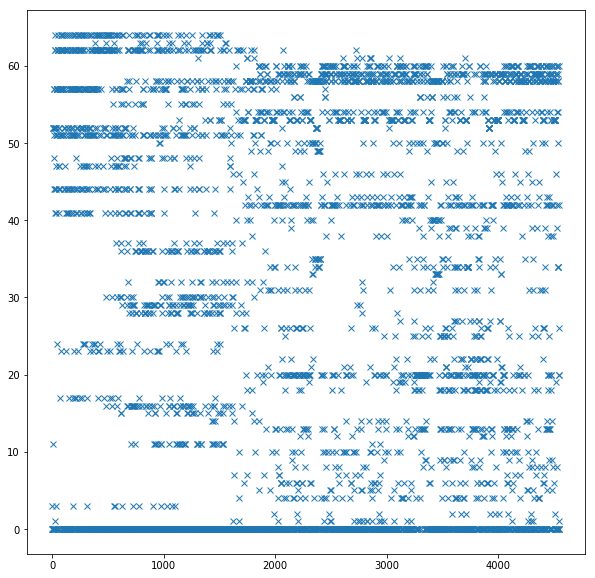

In [30]:
plt.figure(figsize=(10,10))
#lines = [8,23]
#for line in lines:
#    plt.axhline(line,color='k')
plt.plot(labels,'x')


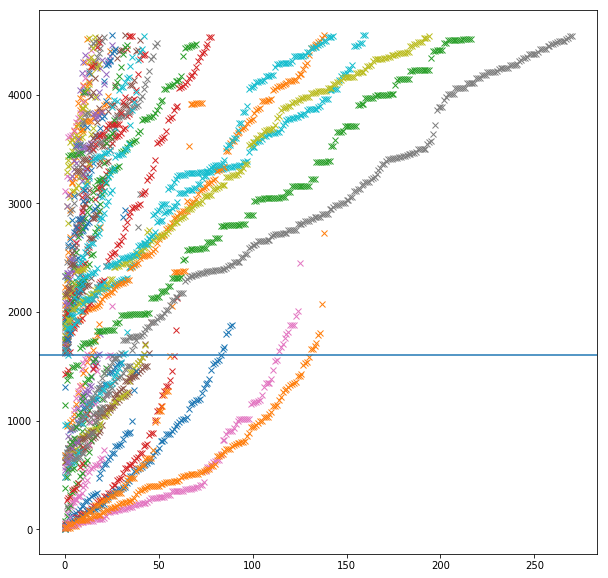

In [38]:
plt.figure(figsize=(10,10))
for i in range(1,max(labels)):
    plt.plot(list(range(len(np.where(labels==i)[0]))),np.where(labels==i)[0],'x')
plt.axhline(1600)

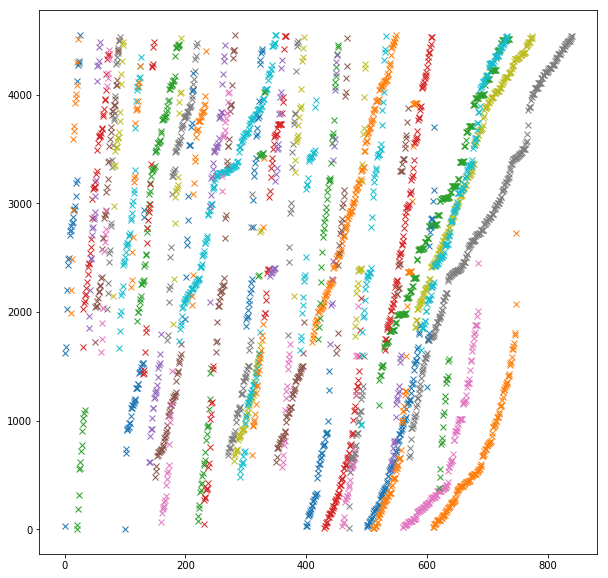

In [26]:
plt.figure(figsize=(10,10))
shift = 0
for i in range(1,max(labels)):
    xs = list(range(len(np.where(labels==i)[0])))
    xs = [i+shift for i in xs]
    plt.plot(xs,np.where(labels==i)[0],'x')
    shift += 10

In [31]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 87.42 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.20 sec


In [32]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [33]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

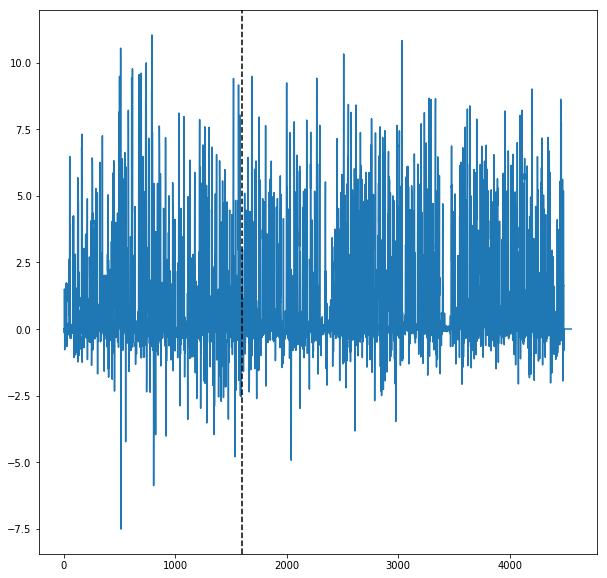

In [40]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'])
plt.axvline(1600,color='k',linestyle='--')

# Average brain for each cluster

In [44]:
brain.shape

(128, 84, 49, 4554)

In [45]:
labels.shape

(4553,)

In [46]:
len(labels)

4553

In [4]:
t0 = time.time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
pca_spatial.shape = (4554, -1)
pca_spatial.shape = (4554, 128, 84, 49)
print('Duration: {}'.format(time.time()-t0))

Duration: 39.99021553993225


In [5]:
brain_reconstructed = np.tensordot(pca_loadings[:,:100], pca_spatial[:100,:,:,:],axes=1)
brain_reconstructed = np.moveaxis(brain_reconstructed,0,-1)

In [5]:
# there is 1 less label because labels are actually for the shift from one time to another
# so, the label at index 0 should get the brain by brain index 1-0
cluster=60
indicies_post = np.where(labels==cluster)[0]
indicies_pre = [i-1 for i in indicies_post]
brains_pre = brain[:,:,:,indicies_pre]
brains_post = brain[:,:,:,indicies_post]
test = brains_post-brains_pre
testmean = np.mean(test,axis=-1)
antsbrain = ants.from_numpy(testmean)
file = os.path.join(directory, '20200108_analysis', 'cluster_{}.nii'.format(cluster))
ants.image_write(antsbrain, file)

In [6]:
# there is 1 less label because labels are actually for the shift from one time to another
# so, the label at index 0 should get the brain by brain index 1-0
cluster=60
indicies_post = np.where(labels==cluster)[0]
indicies_pre = [i-1 for i in indicies_post]
brains_pre = brain_reconstructed[:,:,:,indicies_pre]
brains_post = brain_reconstructed[:,:,:,indicies_post]
test = brains_post-brains_pre
testmean = np.mean(test,axis=-1)
antsbrain = ants.from_numpy(testmean)
file = os.path.join(directory, '20200108_analysis', 'cluster_pc100_{}.nii'.format(cluster))
ants.image_write(antsbrain, file)

In [15]:
brain.shape

(128, 84, 49, 4554)

In [18]:
meanbrain = meanbrain[:,:,:,np.newaxis]

In [19]:
#meanbrain = np.mean(brain, axis=-1)
#meanbrain = meanbrain[:,:,:,0]
brain = brain-meanbrain

In [20]:
state_change = np.mean(brain[:,:,:,:1600],axis=-1) - np.mean(brain[:,:,:,1600:],axis=-1)

In [21]:
antsbrain = ants.from_numpy(state_change)
file = os.path.join(directory, '20200108_analysis', 'state_change_motcorr_green_mean_subtract.nii')
ants.image_write(antsbrain, file)

In [6]:
len(np.where(labels==40)[0])

27

In [55]:
# check logic
# output cluster brains
# could also output from the PC space
# might want to do delta between pre/post and mean.

In [56]:
test.shape

(128, 84, 49, 79)

In [9]:
brain.shape

(128, 84, 49, 4554)

In [9]:
brain_reconstructed.shape

(4554, 128, 84, 49)

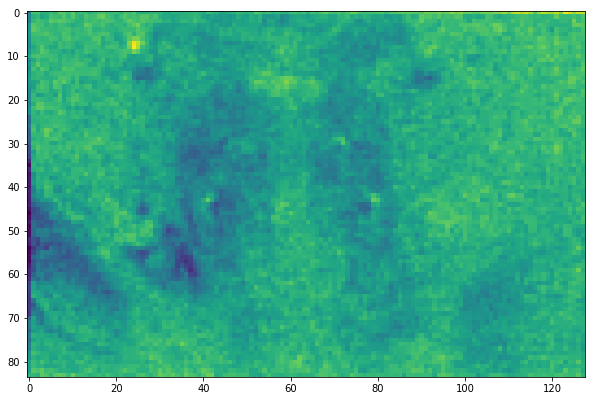

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(brain_reconstructed[0,:,:,30].T)

In [10]:
meanbrain = np.mean(brain,axis=-1)

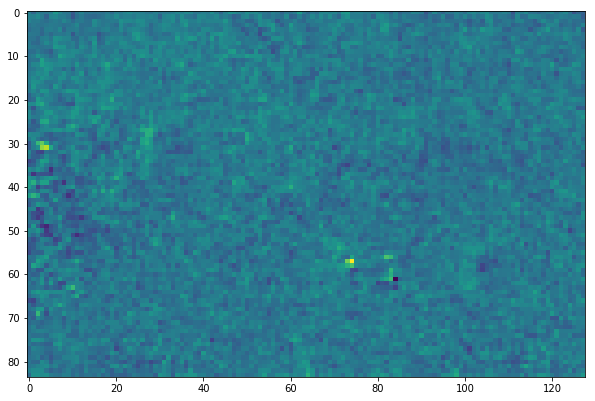

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(state_change[:,:,10].T)

In [12]:
meanbrain.shape

(128, 84, 49)

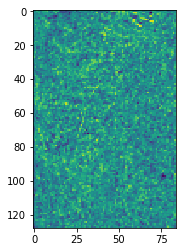

In [67]:
plt.imshow(testmean[:,:,9])

In [6]:
brain.shape

(128, 84, 49, 4554)

In [ ]:
1

In [1]:
3

3